In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor,plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle





In [2]:
df = pd.read_csv('../data/improved_data_52.csv')
df2 = pd.read_csv('../data/improved_data_52.csv')

In [3]:
df.describe()

,Store,Dept,Size,Fuel_Price,week,month,day,Weekly_Sales,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,261083.000000,261083.000000,261083.000000,261083.000000,261083.000000,261083.000000,261083.000000,261083.000000,261083.000000,0.0,0.0,0.0,0.0,0.0,261083.000000,261083.000000
mean,22.126462,44.065627,137439.568183,3.653751,25.511577,6.358932,15.597814,16225.029406,60.311980,NaN,NaN,NaN,NaN,NaN,169.109696,8.277293
std,12.766526,30.601273,60717.527857,0.274466,13.592010,3.105411,8.754838,22534.761596,18.929228,NaN,NaN,NaN,NaN,NaN,38.306911,1.865034
min,1.000000,1.000000,34875.000000,2.974000,1.000000,1.000000,1.000000,-4988.940000,-2.060000,NaN,NaN,NaN,NaN,NaN,126.064000,4.420000
25%,11.000000,18.000000,93638.000000,3.494000,14.000000,4.000000,8.000000,2389.290000,46.650000,NaN,NaN,NaN,NaN,NaN,131.863129,7.343000
50%,22.000000,36.000000,140167.000000,3.659000,25.000000,6.000000,16.000000,7998.550000,62.930000,NaN,NaN,NaN,NaN,NaN,182.046418,8.099000
75%,33.000000,74.000000,202505.000000,3.842000,37.000000,9.000000,23.000000,20520.920000,74.690000,NaN,NaN,NaN,NaN,NaN,210.975957,8.724000
max,45.000000,99.000000,219622.000000,4.468000,52.000000,12.000000,31.000000,693099.360000,100.140000,NaN,NaN,NaN,NaN,NaN,221.315956,14.313000


In [4]:
df['Weekly_Sales'].var()

507815480.198958

/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Mean Squared Error (MSE): 32332000.83
Mean Absolute Error (MAE): 3132.13
R-squared (R2): 0.94


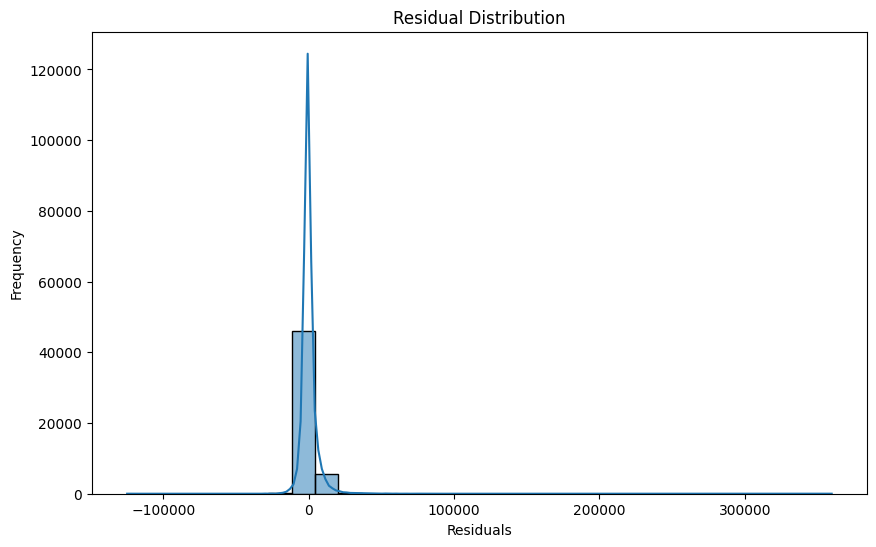

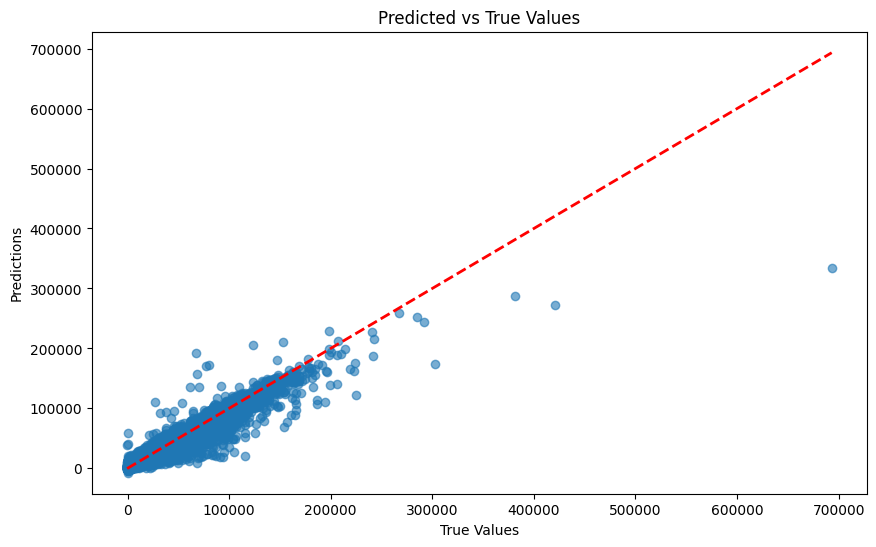

<Figure size 1000x600 with 0 Axes>

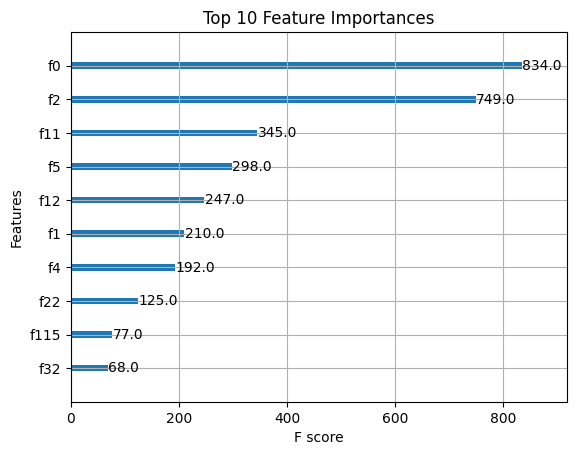


Feature Importances (excluding Dept_):
              Feature  Importance
0               Size    0.006437
3              month    0.001637
2               week    0.001252
134  IsHoliday_False    0.000836
12      Unemployment    0.000703
11               CPI    0.000556
4                day    0.000332
5        Temperature    0.000327
1         Fuel_Price    0.000205
6          MarkDown1    0.000000


In [5]:

target = 'Weekly_Sales'

X = df2.drop(columns=target, axis=1)
y = df2[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['Store', 'Dept', 'IsHoliday', 'Type']
numerical_features = ['Size', 'Fuel_Price', 'week', 'month', 'day', 'Temperature', 'MarkDown1', 'MarkDown2',
                      'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = XGBRegressor(objective='reg:squarederror', random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

xgb_model = pipeline.named_steps['model']
if hasattr(xgb_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    plot_importance(xgb_model, max_num_features=10, importance_type='weight', title='Top 10 Feature Importances')
    plt.show()

try:
    ohe_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    
    all_feature_names = np.concatenate([numerical_features, ohe_columns])
    
    filtered_feature_names = [name for name in all_feature_names if not name.startswith(('Dept_', 'Store_', 'Type_'))]
    
    xgb_model = pipeline.named_steps['model']
    feature_importances = pd.DataFrame({'Feature': all_feature_names, 
                                        'Importance': xgb_model.feature_importances_})
    
    feature_importances_filtered = feature_importances[feature_importances['Feature'].isin(filtered_feature_names)]
    
    feature_importances_filtered = feature_importances_filtered.sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importances (excluding Dept_):\n", feature_importances_filtered.head(10))

except Exception as e:
    print("\nFeature importance calculation failed:", e)



In [6]:
X_test['original_date'] = pd.to_datetime(X_test['original_date'])
X_test['Predicted_Weekly_Sales'] = y_pred
X_test['True_Weekly_Sales'] = y_test




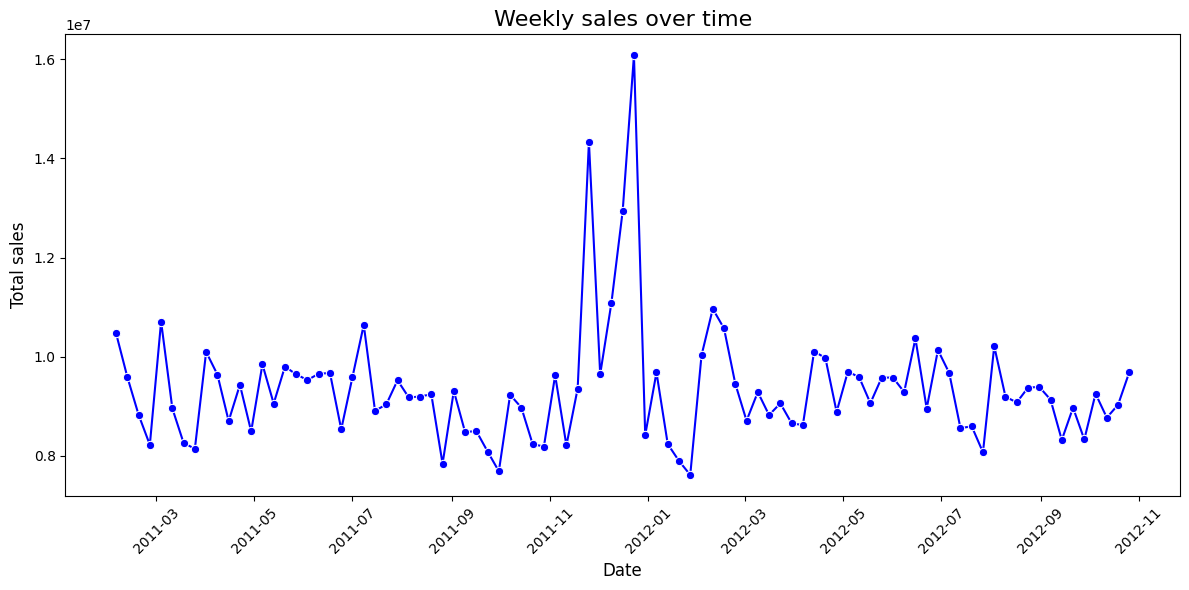

In [7]:

weekly_sales_true = X_test.groupby('original_date')['True_Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales_true, x='original_date', y='True_Weekly_Sales', marker='o', color='b')
plt.title('Weekly sales over time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


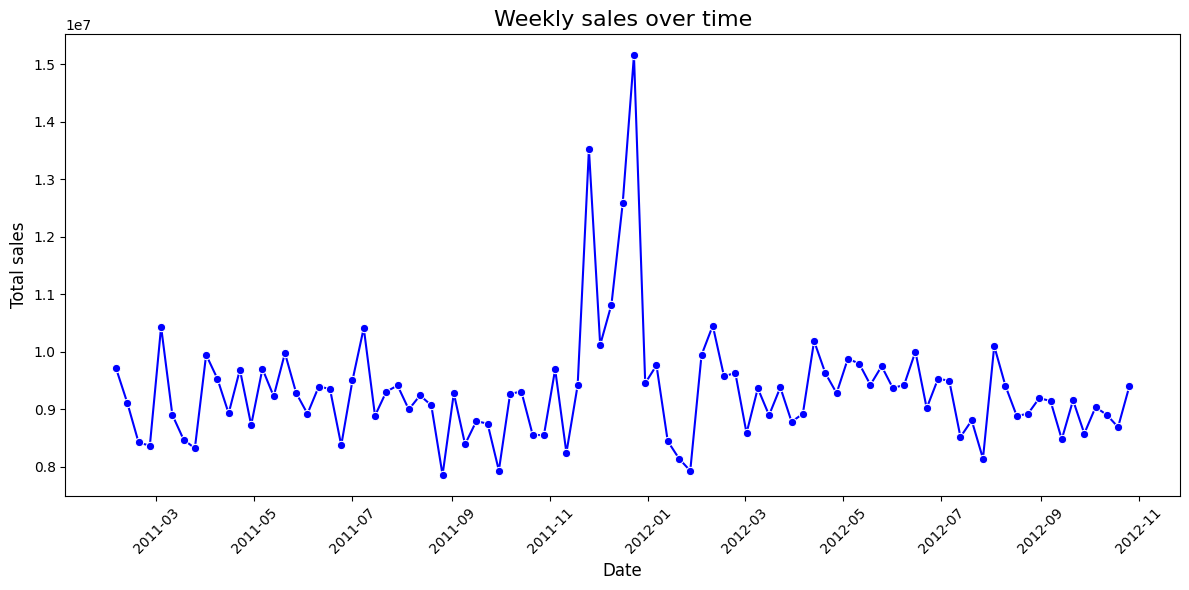

In [8]:
weekly_sales_pred = X_test.groupby('original_date')['Predicted_Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales_pred, x='original_date', y='Predicted_Weekly_Sales', marker='o', color='b')
plt.title('Weekly sales over time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
with open("../src/models/xgboost_model.pkl", "wb") as file:
    pickle.dump(model, file)